In [5]:
import matplotlib.pyplot as plt
%matplotlib inline 
import numpy as np
import keras
import cv2

/home/pelonomi/anaconda3/envs/tensorflowenv/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/pelonomi/anaconda3/envs/tensorflowenv/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/pelonomi/anaconda3/envs/tensorflowenv/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/pelonomi/anaconda3/envs/tensorflowenv/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


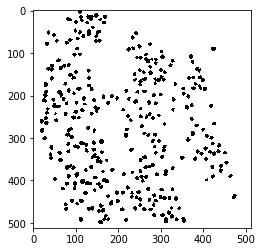

255 1


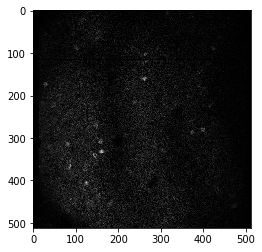

224 0


In [6]:
import cv2
frame_no = 499
cap = cv2.VideoCapture('Databinary/substack500_7fps_00.label.tif') #video_name is the video being called
cap.set(1,frame_no); # Where frame_no is the frame you want
ret, frame = cap.read() # Read the frame
plt.imshow(frame)
plt.show()
print(frame.max(), frame.min())
cap = cv2.VideoCapture('Databinary/substack500_7fps_00.avi') #video_name is the video being called
cap.set(1,frame_no); # Where frame_no is the frame you want
ret, frame = cap.read() # Read the frame
plt.imshow(frame)
plt.show()
print(frame.max(), frame.min())

The input images thus need to be normalised because values are not within the range of 0 and 1. This will hopefully help the network to optimise better

DEFINE MODEL AND TRAINING PROCEDURE

In [98]:
from keras.models import Model
from keras.layers.convolutional import Conv3D, Conv2D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Input, TimeDistributed
import keras.backend as K
import tensorflow as tf

from keras.layers import (ConvLSTM2D, BatchNormalization, Convolution3D, Convolution2D,Conv2D,
                          TimeDistributed, MaxPooling2D, UpSampling2D, Input, merge, Cropping2D, concatenate)


K.tensorflow_backend.set_session(tf.Session(config=tf.ConfigProto(device_count = {'GPU': 0})))

def load_model(batch_size,true_frag_len):
    input_shape = (None, 256, 400, 1)
    input = Input(batch_shape= [batch_size, true_frag_len, 256,400, 1])
    
    x = TimeDistributed(Conv2D(filters=2, kernel_size=(3,3), padding='same',activation='relu'))(input)
    x = TimeDistributed(MaxPooling2D((2, 2), (2, 2)))(x)
    x = BatchNormalization()(x)
    x = ConvLSTM2D(filters=14, kernel_size=(3, 3),
                       input_shape=input_shape,
                       padding='same', 
                       return_sequences=True,
                       stateful = True)(x)
    x = BatchNormalization()(x)
    x = TimeDistributed(Conv2D(filters=2, kernel_size=(3,3), padding='same',activation='relu'))(x)
    
    upsl_1 = TimeDistributed(UpSampling2D((2, 2)))(x)
    output = TimeDistributed(Conv2D(filters=1, kernel_size=(1,1), padding='same', activation='sigmoid'), name='output')(upsl_1)
    # output = Conv3D(filters=1, kernel_size=(3, 3, 3),
    #                    activation='sigmoid',
    #                    padding='same', data_format='channels_last')(x)


    model_stateful_batch1 = Model(inputs = [input], output=[output])
    model_stateful_batch1.compile(loss='binary_crossentropy', optimizer='adadelta')
    model_stateful_batch1.summary()
    return model_stateful_batch1

In [107]:
def train_model(model, no_samples, no_frags, generator):
    
    print("Number of training reps " + str(reps_for_samples))
    for reps in range(reps_for_samples):
        if reps%(no_frags) == 0:
            print ('Time to reset states')
            model.reset_states()
        train_loss = 0
        X,Y = next(generator.generate())
        train_loss += model.train_on_batch(X, Y)
        #print ('# epoch', reps, '  loss ', train_loss/float(Y.shape[0]))
        #if reps%no_frags == 0:
        if reps%50 == 0:
            print ('# epoch', reps, '  loss ', train_loss/float(Y.shape[0]))
            print(train_loss)
    print ('# epoch', reps, '  loss ', train_loss/float(Y.shape[0]))
    print(train_loss)
    return model

## STOCHASTIC
## STATEFUL batch_shape = [1, frag_len, x, y, 1]
    1 sample at a time
    update made after no_fragments batches
    y = [1, 1, x, y, 1]

DEFINE DATA FEEDER

There are two ways to sample the data as illustrated below. Check it out. The only difference is how indexes are defined for data range of each fragment and then the no of resulting fragments.

In [25]:
class Batch_size_1_Generator(object):

    def __init__(self, frag_len, steps = 1):
        self.frag_len = frag_len
        #print(frag_len)
        # this will track the progress of the batches sequentially through the
        # data set - once the data reaches the end of the data set it will reset
        # back to zero
        self.current_idx = 0
        self.current_count = 0
        self.data = None
        # dimensions expected by the network
        self.dims = (400,256)
        self.steps = steps
    
        #self.dup_rows()
        # skip_step is the number of words which will be skipped before the next
        # batch is skimmed from the data set

    def dup_rows(self, a, indx, num_dups=1):
        return np.insert(a,[indx+1]*num_dups,a[indx],axis=0)
    
    def _resizeNnormalize(self, data, dimso):
        """
        data : the image to be resized 
        dimso : the dimensions to be resized to (tuple)
        """
        data = cv2.resize(data, dimso)
        img = cv2.cvtColor(data, cv2.COLOR_BGR2GRAY)
        nomalized = img/255
        return nomalized
    
    
    def generate(self):
        # this generator returns no_frag fragments for each sample before moving to the next sample
        while True:
           
            if self.current_count == 0:
                self.current_idx = np.random.randint(10)
            video = cv2.VideoCapture('Databinary/substack500_7fps_0' + str(self.current_idx) + '.avi')

            data_len = 500
            # find out number of fragments for data
            no_frags = int((data_len-frag_len + 1)/steps)
            #no_frags = int(data_len/frag_len)
            
            #print("No frags inside " + str(no_frags))
            self.current_count += 1
            print('current sample number: ' + str(self.current_idx)+', Fragment ' + str(self.current_count)+ ' of ' + str(no_frags))
            
            if self.current_count == no_frags:
                print(self.current_count)
                self.current_count = 0
            data_range = (self.current_count,self.current_count+ self.frag_len)
            #print(data_range)
            
            x = []

            # data_range is the range of frames to be fetched for each fragment
            indxs = np.arange(current_count*steps,current_count*steps+ frag_len, steps)
            #indxs = np.arange(self.current_count*self.frag_len,(self.current_count+1)* self.frag_len, steps)

            #for indexer in range(data_range[0],data_range[1]):
            for indexer in indxs:

                video.set(1,indexer) # Where frame_no is the frame you want
                ret, frame = video.read() # Read the frame
                x.append(self._resizeNnormalize(frame, self.dims))
         
            #print('No frags ' + str(no_frags))
            
             
            labels = cv2.VideoCapture('Databinary/substack500_7fps_0' + str(self.current_idx) + '.label.tif')
            labels.set(1,1)
            ret,lab_frame = labels.read()
            y = []
            for indx in range(int((self.frag_len+1)/self.steps)):
            #for indx in range(int((self.frag_len+1)/self.steps)-1):

                y.append(self._resizeNnormalize(lab_frame, self.dims))
                
            y = np.expand_dims(y, axis=-1)
            x = np.expand_dims(x, axis=-1)
            y = np.expand_dims(y, axis=0)
            x = np.expand_dims(x, axis=0)
           
            #yield x,y
            yield x,y
            

no of fragments and length of fragments changes with the step size so the real length becomes (frag_len+1)/steps and number of fragments is (data_len-frag_len + 1)/steps

In [26]:
example = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20, 21, 22]
data_len = len(example)
frag_len = 11
steps = 2
no_frags = int((data_len-frag_len + 1)/steps)
print(no_frags)

for current_count in range(no_frags):
    #ranger = list(range(current_count,current_count+ frag_len))
    indx = np.arange(current_count*steps,current_count*steps+ frag_len, steps)
    print(np.array(example)[indx.astype(int)])
(np.array(example)[indx.astype(int)]).shape

6
[ 1  3  5  7  9 11]
[ 3  5  7  9 11 13]
[ 5  7  9 11 13 15]
[ 7  9 11 13 15 17]
[ 9 11 13 15 17 19]
[11 13 15 17 19 21]


(6,)

no of fragments does not change with the step size but, the actual length of the fragment is changed by the step size. so the real length becomes (frag_len+1)/steps 

In [27]:
example = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20, 21, 22]
data_len = len(example)
frag_len = 11
steps = 2
no_frags = int(data_len-frag_len + 1)
print(no_frags)

for current_count in range(no_frags):
    #ranger = list(range(current_count,current_count+ frag_len))
    indx = np.arange(current_count,current_count+ frag_len, steps)
    print(np.array(example)[indx.astype(int)])
(np.array(example)[indx.astype(int)])

12
[ 1  3  5  7  9 11]
[ 2  4  6  8 10 12]
[ 3  5  7  9 11 13]
[ 4  6  8 10 12 14]
[ 5  7  9 11 13 15]
[ 6  8 10 12 14 16]
[ 7  9 11 13 15 17]
[ 8 10 12 14 16 18]
[ 9 11 13 15 17 19]
[10 12 14 16 18 20]
[11 13 15 17 19 21]
[12 14 16 18 20 22]


array([12, 14, 16, 18, 20, 22])

Quick check to make sure the data is loaded correctly by the data generator. Also a quick check to make sure the images returned are nomalised (value range between 0 and 1). 

NB. Make sure current sample number of next output block is the same as the label vect that is read by cv2 when drawing otherwise images wont match and you might think it is not working

In [9]:
steps = 1
frag_len = 40
true_frag_len = int((frag_len+1)/steps)
print('True fragment length ' +str(true_frag_len))
gener_obj = Batch_size_1_Generator(frag_len, steps)
gener = gener_obj.generate()
X,y = next(gener)

True fragment length 41
current sample number: 6, Fragment 1 of 461


In [10]:
X.shape, y.shape

((1, 40, 256, 400, 1), (1, 40, 256, 400, 1))

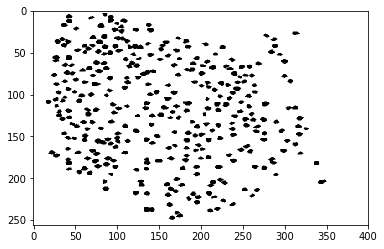

Max value: 255


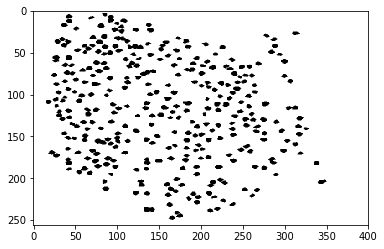

Max value: 1.0


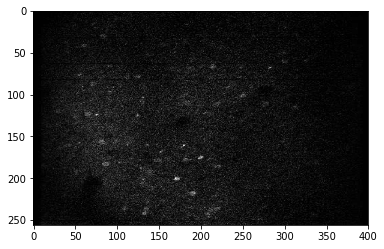

Max value: 0.6274509803921569


In [474]:
vect = cv2.VideoCapture("Databinary/substack500_7fps_03.label.tif")
vect.set(1,1)
ret,lab_frame = vect.read()
lab_frame = cv2.resize(lab_frame,(400,256))
#truth = lab_frame[0].reshape(256,400)
plt.imshow(lab_frame, cmap = 'gray')
plt.show()
print('Max value: ' + str(lab_frame.max()))

plt.imshow(y[0][0].reshape(256,400), cmap = 'gray')
plt.show()
print('Max value: ' + str(y[0][0].max()))

plt.imshow(X[0][0].reshape(256,400), cmap = 'gray')
plt.show()
print('Max value: ' + str(X[0][0].max()))

TRAIN

In [103]:
data_len = 500
steps = 2
frag_len = 40
true_frag_len = int((frag_len+1)/steps)
no_frags = int((data_len-frag_len + 1)/steps)
batch_size = 1
no_videos = 8
reps_for_samples = no_videos*no_frags

#no_frags = int(data_len/frag_len)


print(no_frags)
print(true_frag_len)
model_stateful_batch1 = load_model(batch_size,true_frag_len)
#model_stateful_batch1 = load_model(frag_len)

gener = Batch_size_1_Generator(frag_len, steps)

230
20
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (1, 20, 256, 400, 1)      0         
_________________________________________________________________
time_distributed_37 (TimeDis (1, 20, 256, 400, 2)      20        
_________________________________________________________________
time_distributed_38 (TimeDis (1, 20, 128, 200, 2)      0         
_________________________________________________________________
batch_normalization_19 (Batc (1, 20, 128, 200, 2)      8         
_________________________________________________________________
conv_lst_m2d_10 (ConvLSTM2D) (1, 20, 128, 200, 14)     8120      
_________________________________________________________________
batch_normalization_20 (Batc (1, 20, 128, 200, 14)     56        
_________________________________________________________________
time_distributed_39 (TimeDis (1, 20, 128, 200, 2)      254       
___

/home/pelonomi/anaconda3/envs/tensorflowenv/lib/python3.5/site-packages/ipykernel_launcher.py:37: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=[<tf.Tenso...)`


In [ ]:
model_stateful_batch1_trained = train_model(model_stateful_batch1, reps_for_samples, no_frags, gener)

PREDICT ON TRAINED MODEL

In [31]:
# Predict using just a single sample loaded from file
gener_1 = Batch_size_1_Generator(frag_len, steps).generate()

In [32]:
# this just tests out one sample. I think it is necessary to reset states on prediction too
stateful_preds = []
model_stateful_batch1_trained.reset_states()
for fragment in range(no_frags):
    X,Y = next(gener_1)
    stateful_batch_1 = model_stateful_batch1_trained.predict_on_batch(X)
    stateful_preds.append(stateful_batch_1)
model_stateful_batch1_trained.reset_states() 

current sample number: 2, Fragment 1 of 230
current sample number: 2, Fragment 2 of 230
current sample number: 2, Fragment 3 of 230
current sample number: 2, Fragment 4 of 230
current sample number: 2, Fragment 5 of 230
current sample number: 2, Fragment 6 of 230
current sample number: 2, Fragment 7 of 230
current sample number: 2, Fragment 8 of 230
current sample number: 2, Fragment 9 of 230
current sample number: 2, Fragment 10 of 230
current sample number: 2, Fragment 11 of 230
current sample number: 2, Fragment 12 of 230
current sample number: 2, Fragment 13 of 230
current sample number: 2, Fragment 14 of 230
current sample number: 2, Fragment 15 of 230
current sample number: 2, Fragment 16 of 230
current sample number: 2, Fragment 17 of 230
current sample number: 2, Fragment 18 of 230
current sample number: 2, Fragment 19 of 230
current sample number: 2, Fragment 20 of 230
current sample number: 2, Fragment 21 of 230
current sample number: 2, Fragment 22 of 230
current sample numb

current sample number: 2, Fragment 182 of 230
current sample number: 2, Fragment 183 of 230
current sample number: 2, Fragment 184 of 230
current sample number: 2, Fragment 185 of 230
current sample number: 2, Fragment 186 of 230
current sample number: 2, Fragment 187 of 230
current sample number: 2, Fragment 188 of 230
current sample number: 2, Fragment 189 of 230
current sample number: 2, Fragment 190 of 230
current sample number: 2, Fragment 191 of 230
current sample number: 2, Fragment 192 of 230
current sample number: 2, Fragment 193 of 230
current sample number: 2, Fragment 194 of 230
current sample number: 2, Fragment 195 of 230
current sample number: 2, Fragment 196 of 230
current sample number: 2, Fragment 197 of 230
current sample number: 2, Fragment 198 of 230
current sample number: 2, Fragment 199 of 230
current sample number: 2, Fragment 200 of 230
current sample number: 2, Fragment 201 of 230
current sample number: 2, Fragment 202 of 230
current sample number: 2, Fragment

In [42]:
len(stateful_preds), stateful_preds[0][0].shape

(230, (20, 256, 400, 1))

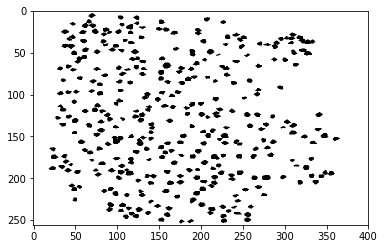

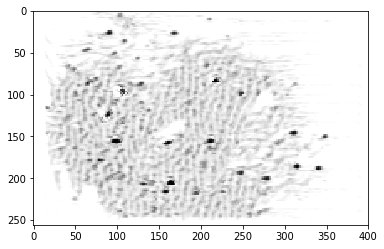

In [48]:
predicted = stateful_preds[229][0].reshape(20,256,400)

vect = cv2.VideoCapture("Databinary/substack500_7fps_02.label.tif")
vect.set(1,1)
ret,lab_frame = vect.read()
lab_frame = cv2.resize(lab_frame,(400,256))
#truth = lab_frame[0].reshape(256,400)
plt.imshow(lab_frame, cmap = 'gray')
plt.show()

#predicted result
plt.imshow(predicted[19], cmap = 'gray')
plt.show()

## Mini-batch
## STATEFUL batch_shape = [batch_size, frag_len, x, y, 1]
    8 samples at a time
    update made after no_fragments batches
    y = [8, 1, x, y, 1]

In [120]:
class Batch_size_n_Generator(object):

    def __init__(self, batch_size,frag_len,steps = 1):
        self.frag_len = frag_len
        #print(frag_len)
        # this will track the progress of the batches sequentially through the
        # data set - once the data reaches the end of the data set it will reset
        # back to zero
        self.current_idxs = [] 
        self.current_count = 0
        self.data = None
        # dimensions expected by the network
        self.dims = (400,256)
        self.steps = steps
        self.batch_size = batch_size
    
        #self.dup_rows()
        # skip_step is the number of words which will be skipped before the next
        # batch is skimmed from the data set

    def dup_rows(self, a, indx, num_dups=1):
        return np.insert(a,[indx+1]*num_dups,a[indx],axis=0)
    
    def _resizeNnormalize(self, data, dimso):
        """
        data : the image to be resized 
        dimso : the dimensions to be resized to (tuple)
        """
        data = cv2.resize(data, dimso)
        img = cv2.cvtColor(data, cv2.COLOR_BGR2GRAY)
        nomalized = img/255
        return nomalized
    
    def _fetchframes(self, indxs, video):
        frames = []
        for indexer in indxs:
            video.set(1,indexer) # Where frame_no is the frame you want
            ret, frame = video.read() # Read the frame
            frames.append(self._resizeNnormalize(frame, self.dims))
        return(frames)
    
    def _fetchlabels(self, label, true_frag_len):
        frames = []
        label.set(1,1)
        ret,lab_frame = label.read()
        label_frame = self._resizeNnormalize(lab_frame, self.dims) 
        y = [label_frame for indx in range(true_frag_len)]
        return(y)
    
    
    def generate(self):
        # this generator returns no_frag fragments for each sample before moving to the next sample
        while True:
           
            if self.current_count == 0:
                self.current_idxs = [np.random.randint(10) for i in range(self.batch_size)]
                print(self.current_idxs)
            
            
            #self.data = [np.load('dummies/video_' + str(ind) + '.npy') for ind in self.current_idxs]
            self.data = [cv2.VideoCapture('Databinary/substack500_7fps_0' + str(ind) + '.avi') for ind in self.current_idxs]
            #video = cv2.VideoCapture('Databinary/substack500_7fps_0' + str(self.current_idx) + '.avi')
            data_len = 500
            # find out number of fragments for data
            no_frags = int((data_len-frag_len + 1)/steps)
            #no_frags = int(data_len/frag_len)
            
            #print("No frags inside " + str(no_frags))
            self.current_count += 1
            print('current sample number: ' + str(self.current_idxs)+', Fragment ' + str(self.current_count)+ ' of ' + str(no_frags))
            
            if self.current_count == no_frags:
                print(self.current_count)
                self.current_count = 0
            

            # data_range is the range of frames to be fetched for each fragment
            indxs = np.arange(current_count*steps,current_count*steps+ frag_len, steps)
            x = [self._fetchframes(indxs,video) for video in self.data]
                
 
    
            labels = [(cv2.VideoCapture('Databinary/substack500_7fps_0' + str(ind) + '.label.tif')) for ind in self.current_idxs]
            y = [self._fetchlabels(lebel, len(x[0])) for lebel in labels]
           
                
            y = np.expand_dims(y, axis=-1)
            x = np.expand_dims(x, axis=-1)

           
            #yield x,y
            yield x,y
            

Check that generator is producing the right data

In [81]:
steps = 1
frag_len = 40
true_frag_len = int((frag_len+1)/steps)
batch_size = 4
print('True fragment length ' +str(true_frag_len))
gener_obj = Batch_size_n_Generator(frag_len, batch_size,steps)
gener = gener_obj.generate()
X,y = next(gener)

True fragment length 41
[0, 6, 9, 3]
current sample number: [0, 6, 9, 3], Fragment 1 of 461


In [82]:
X.shape, y.shape

((4, 40, 256, 400, 1), (4, 40, 256, 400, 1))

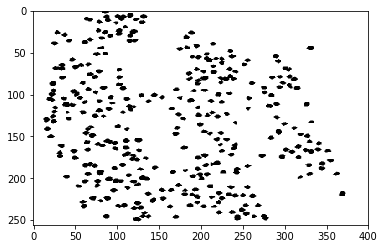

Max value: 255


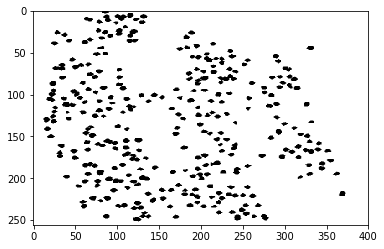

Max value: 1.0


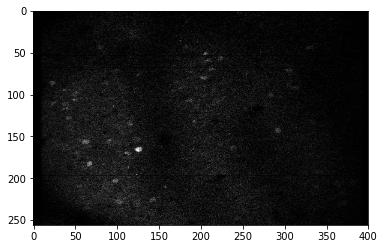

Max value: 0.9058823529411765


In [95]:
vect = cv2.VideoCapture("Databinary/substack500_7fps_00.label.tif")
vect.set(1,1)
ret,lab_frame = vect.read()
lab_frame = cv2.resize(lab_frame,(400,256))
#truth = lab_frame[0].reshape(256,400)
plt.imshow(lab_frame, cmap = 'gray')
plt.show()
print('Max value: ' + str(lab_frame.max()))

plt.imshow(y[0][0].reshape(256,400), cmap = 'gray')
plt.show()
print('Max value: ' + str(y[0][0].max()))

plt.imshow(X[0][1].reshape(256,400), cmap = 'gray')
plt.show()
print('Max value: ' + str(X[0][0].max()))

TRAIN ON MODEL

In [121]:
data_len = 500
steps = 2
frag_len = 40
true_frag_len = int((frag_len+1)/steps)
no_frags = int((data_len-frag_len + 1)/steps)
batch_size = 4
no_samples = 8
no_batches = int(no_samples/batch_size)
reps_for_samples = no_batches*no_frags
#no_frags = int(data_len/frag_len)


print(no_frags)
print(true_frag_len)
model_stateful_batchn = load_model(batch_size,true_frag_len)
#model_stateful_batch1 = load_model(frag_len)

gener = Batch_size_n_Generator(batch_size, frag_len, steps)

230
20
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (4, 20, 256, 400, 1)      0         
_________________________________________________________________
time_distributed_69 (TimeDis (4, 20, 256, 400, 2)      20        
_________________________________________________________________
time_distributed_70 (TimeDis (4, 20, 128, 200, 2)      0         
_________________________________________________________________
batch_normalization_35 (Batc (4, 20, 128, 200, 2)      8         
_________________________________________________________________
conv_lst_m2d_18 (ConvLSTM2D) (4, 20, 128, 200, 14)     8120      
_________________________________________________________________
batch_normalization_36 (Batc (4, 20, 128, 200, 14)     56        
_________________________________________________________________
time_distributed_71 (TimeDis (4, 20, 128, 200, 2)      254       
___

/home/pelonomi/anaconda3/envs/tensorflowenv/lib/python3.5/site-packages/ipykernel_launcher.py:37: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=[<tf.Tenso...)`


In [ ]:
model_stateful_batchn_trained = train_model(model_stateful_batchn, reps_for_samples, no_frags, gener)

Number of training reps 460
Time to reset states
[4, 4, 7, 3]
current sample number: [4, 4, 7, 3], Fragment 1 of 230
# epoch 0   loss  0.19532597064971924
0.781303882598877
current sample number: [4, 4, 7, 3], Fragment 2 of 230
current sample number: [4, 4, 7, 3], Fragment 3 of 230
current sample number: [4, 4, 7, 3], Fragment 4 of 230
current sample number: [4, 4, 7, 3], Fragment 5 of 230
current sample number: [4, 4, 7, 3], Fragment 6 of 230
current sample number: [4, 4, 7, 3], Fragment 7 of 230
current sample number: [4, 4, 7, 3], Fragment 8 of 230
current sample number: [4, 4, 7, 3], Fragment 9 of 230
current sample number: [4, 4, 7, 3], Fragment 10 of 230
current sample number: [4, 4, 7, 3], Fragment 11 of 230
current sample number: [4, 4, 7, 3], Fragment 12 of 230
current sample number: [4, 4, 7, 3], Fragment 13 of 230
current sample number: [4, 4, 7, 3], Fragment 14 of 230
current sample number: [4, 4, 7, 3], Fragment 15 of 230
current sample number: [4, 4, 7, 3], Fragment 16 of

PREDICT ON TRAINED MODEL